In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline



In [2]:
# Load the dataset
df = pd.read_csv('medical_students_dataset.csv')
df = df.drop(columns=['Student ID'])



In [3]:
# Split dataset into features and target variable
X = df.drop(columns=['Diabetes'])  # Drop 'Diabetes' from features
Y = df['Diabetes']  # Target variable

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Confirm output
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


(160000, 11) (40000, 11) (160000,) (40000,)


In [4]:
# Explore the dataset
print(df.info())      
# Overview of data types and missing values
print(df.describe())  # Statistical summary of numerical columns
print(df.head())      # Preview first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             180000 non-null  float64
 1   Gender          180000 non-null  object 
 2   Height          180000 non-null  float64
 3   Weight          180000 non-null  float64
 4   Blood Type      180000 non-null  object 
 5   BMI             180000 non-null  float64
 6   Temperature     180000 non-null  float64
 7   Heart Rate      180000 non-null  float64
 8   Blood Pressure  180000 non-null  float64
 9   Cholesterol     180000 non-null  float64
 10  Diabetes        180000 non-null  object 
 11  Smoking         180000 non-null  object 
dtypes: float64(8), object(4)
memory usage: 18.3+ MB
None
                 Age         Height         Weight            BMI  \
count  180000.000000  180000.000000  180000.000000  180000.000000   
mean       26.021561     174.947103      69.97158

In [5]:
# Check percentage of missing values
print("\nPercentage of missing values for each column:")
print((df.isnull().sum() / len(df)) * 100)
#duplicate rows
df.duplicated().sum()




Percentage of missing values for each column:
Age               10.0
Gender            10.0
Height            10.0
Weight            10.0
Blood Type        10.0
BMI               10.0
Temperature       10.0
Heart Rate        10.0
Blood Pressure    10.0
Cholesterol       10.0
Diabetes          10.0
Smoking           10.0
dtype: float64


np.int64(9296)

In [6]:
# Handle duplicates
df = df.drop_duplicates()
print("\n after removing duplicate rows")
df.duplicated().sum()


 after removing duplicate rows


np.int64(0)

In [7]:
# Identify categorical and numerical columns
categorical_columns = ['Diabetes','Smoking','Gender','Blood Type']
numerical_columns = ['Age','BMI','Height','Weight','Cholesterol','Temperature','Heart Rate','Blood Pressure']

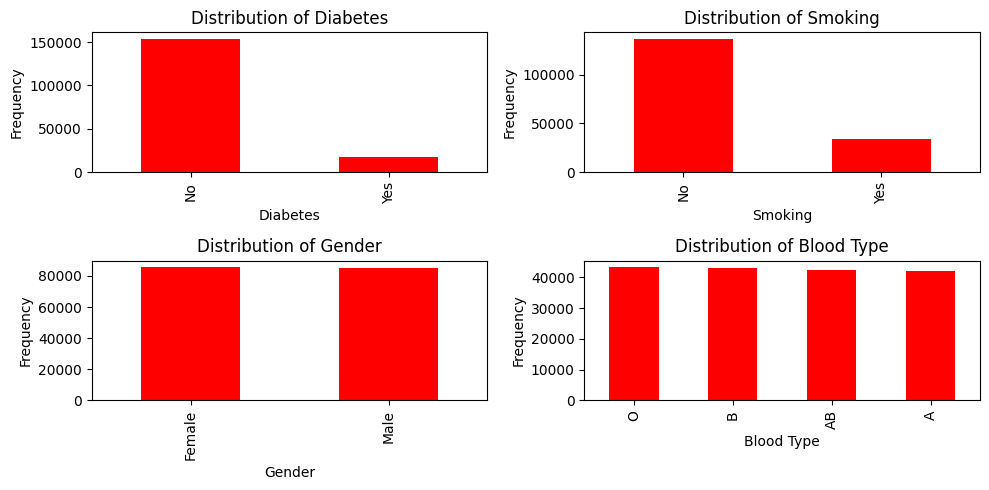

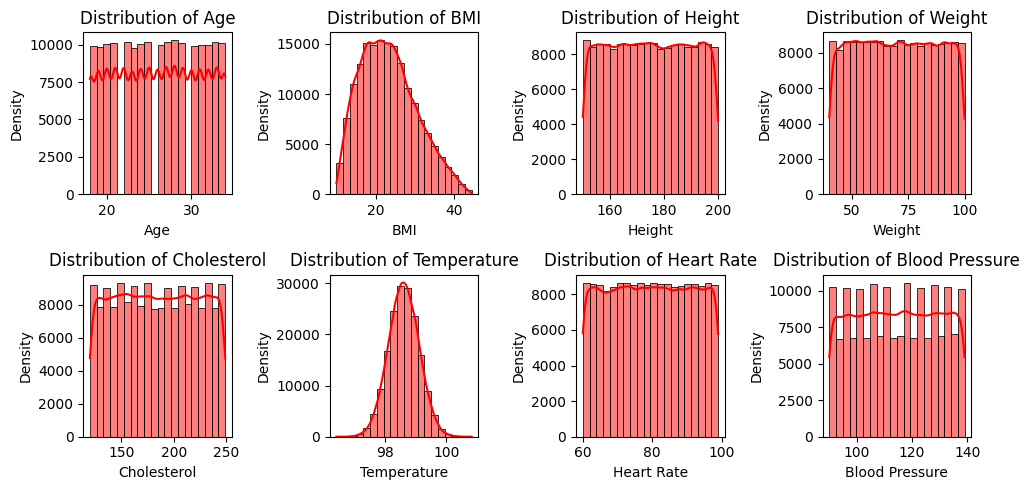

In [8]:
# Plot bar graphs for categorical variables
plt.figure(figsize=(10, 5))
for i, col in enumerate(categorical_columns):
    plt.subplot(2, (len(categorical_columns) + 1) // 2, i + 1)
    df[col].value_counts().plot(kind='bar', color='red')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot histograms for numerical variables
plt.figure(figsize=(10, 5))
for i, col in enumerate(numerical_columns):
    plt.subplot(2, (len(numerical_columns) + 1) // 2, i + 1)
    sns.histplot(df[col], kde=True, color='red', bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [9]:
def compute_and_impute_remaining_values(df):
    """
    Computes and imputes missing values for 'Height', 'Weight', and 'BMI' 
    based on the BMI formula and ensures consistency.
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'Height', 'Weight', and 'BMI'.

    Returns:
    - pd.DataFrame: Updated DataFrame with imputed values.
    """
    for index, row in df.iterrows():
        if pd.isnull(row['BMI']) and not pd.isnull(row['Weight']) and not pd.isnull(row['Height']):
            df.at[index, 'BMI'] = row['Weight'] / (row['Height'] ** 2)
        elif pd.isnull(row['Weight']) and not pd.isnull(row['BMI']) and not pd.isnull(row['Height']):
            df.at[index, 'Weight'] = row['BMI'] * (row['Height'] ** 2)
        elif pd.isnull(row['Height']) and not pd.isnull(row['BMI']) and not pd.isnull(row['Weight']):
            df.at[index, 'Height'] = np.sqrt(row['Weight'] / row['BMI'])

    mean_height = df['Height'].mean()
    mean_weight = df['Weight'].mean()
    mean_bmi = df['BMI'].mean()

    for index, row in df.iterrows():
        if pd.isnull(row['Height']):
            df.at[index, 'Height'] = mean_height
        if pd.isnull(row['Weight']):
            df.at[index, 'Weight'] = mean_weight
        if pd.isnull(row['BMI']):
            df.at[index, 'BMI'] = mean_bmi

    return df
df[['Height', 'Weight', 'BMI']] = compute_and_impute_remaining_values(df[['Height', 'Weight', 'BMI']])

In [10]:
def impute_categorical_randomly(df, columns_to_impute=['Blood Type', 'Gender','Smoking']):
    """
    Imputes missing categorical values in specified columns with random choices 
    from the non-missing values in the column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - columns_to_impute (list): List of categorical columns to impute. 
      Defaults to ['Blood Type', 'Gender'] if not provided.
    """
   
    for column_name in columns_to_impute:
        # Get unique non-null values from the column
        unique_values = df[column_name].dropna().unique()
        if len(unique_values) > 0:
            # Impute missing values with random choices from existing non-missing values
            df[column_name] = df[column_name].apply(
                lambda x: x if pd.notna(x) else np.random.choice(unique_values)
            )
        else:
            print(f"Column '{column_name}' has no unique values to use for imputaton.")
    df=impute_categorical_randomly(df,['Blood Type', 'Gender','Smoking'])

In [11]:
def replace_nan_with_mean(df,columns=['Temperature', 'Heart Rate', 'Blood Pressure', 'Cholesterol', 'Age']):
    """
    Replace NaN values with the mean for specified columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to process.

    Returns:
        pd.DataFrame: The DataFrame with NaN values replaced by column means.
    """
    for column in columns:
        if column in df.columns:
            # Replace NaN with the mean of the column
            df[column] = df[column].fillna(df[column].mean())
    return df  # Return the modified DataFrame

# Example usage
# Call the function after defining it
df = replace_nan_with_mean(df, ['Temperature', 'Heart Rate', 'Blood Pressure', 'Cholesterol', 'Age'])

In [12]:
def encode_data(df):
    """
    Encodes all categorical columns using Label Encoding.
    This will transform each unique category into a distinct integer within the same column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: The DataFrame with categorical columns encoded as numerical values.
    """
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Apply label encoding to all categorical columns
    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column])

    return df

# Example usage
# Assuming df is your DataFrame containing categorical columns
df = encode_data(df)

# Check the transformed DataFrame
print(df.head())

         Age  Gender      Height     Weight  Blood Type        BMI  \
0  18.000000       0  161.777924  72.354947           3  27.645835   
1  26.021279       1  152.069157  47.630941           2   0.002060   
2  32.000000       0  182.537664  55.741083           0  16.729017   
3  30.000000       1  182.112867  63.332207           2  19.096042   
4  23.000000       0  160.013481  46.234173           3  21.329119   

   Temperature  Heart Rate  Blood Pressure  Cholesterol  Diabetes  Smoking  
0    98.601141        95.0      109.000000        203.0         0        2  
1    98.714977        93.0      104.000000        163.0         0        0  
2    98.260293        76.0      130.000000        216.0         1        0  
3    98.839605        99.0      112.000000        141.0         0        1  
4    98.480008        95.0      114.564494        231.0         0        0  


In [13]:
def predict_diabetes_with_knn_imputer(df):
    """
    Predict diabetes values using KNN imputer based on smoking, BMI, heart rate, blood pressure, and age.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the relevant features and target variable.

    Returns:
    - pd.Series: Predicted diabetes values.
    """
    
    # Select relevant features and target variable
    features = ['Smoking', 'BMI', 'Heart Rate', 'Blood Pressure', 'Age']
    target = 'Diabetes'
    
    # Check if all required columns are present
    if not all(col in df.columns for col in features + [target]):
        raise ValueError("DataFrame must contain the following columns: " + ", ".join(features + [target]))
    
    # Split dataset into features and target variable
    X = df[features]
    y = df[target]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)

    # Impute missing values in the training and test sets
    X_train_imputed = knn_imputer.fit_transform(X_train)
    X_test_imputed = knn_imputer.transform(X_test)

    # Train a Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train_imputed, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_imputed)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the model for Diabetes: {accuracy * 100:.2f}%")

    # Display classification report for more detailed evaluation
    print("\nClassification Report for Diabetes:")
    print(classification_report(y_test, y_pred))

    return pd.Series(y_pred, index=X_test.index)

# Example usage
# df = pd.read_csv('medical_students_dataset.csv')  # Load your dataset
# predictions = predict_diabetes_with_knn_imputer(df)
# print(predictions)


In [14]:
# Check percentage of missing values
print("\nPercentage of missing values for each column:")
print((df.isnull().sum() / len(df)) * 100)
#duplicate rows
df.duplicated().sum()




Percentage of missing values for each column:
Age               0.0
Gender            0.0
Height            0.0
Weight            0.0
Blood Type        0.0
BMI               0.0
Temperature       0.0
Heart Rate        0.0
Blood Pressure    0.0
Cholesterol       0.0
Diabetes          0.0
Smoking           0.0
dtype: float64


np.int64(0)

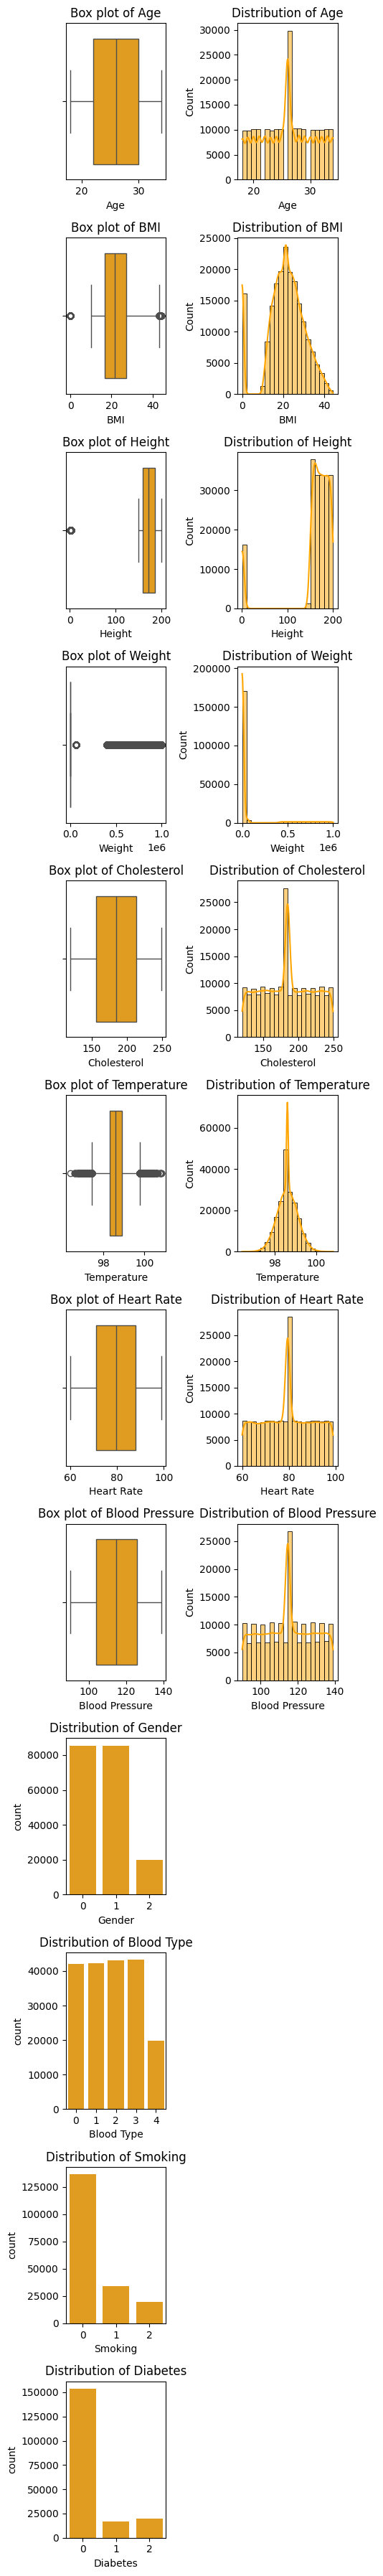

In [15]:

def plot_box_and_distribution(df, numerical_columns, categorical_columns):
    """
    Plots box plots and distribution graphs for numerical columns and bar plots for categorical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        numerical_columns (list): List of numerical columns to plot.
        categorical_columns (list): List of categorical columns to plot.
    """
    # Create a figure with subplots
    fig, axes = plt.subplots(len(numerical_columns) + len(categorical_columns), 2, figsize=(5, 3 * (len(numerical_columns) + len(categorical_columns))))
    
    # Plot for numerical columns
    for i, column in enumerate(numerical_columns):
        # Box plot on the first column of subplots
        sns.boxplot(ax=axes[i, 0], data=df, x=column, color='orange')
        axes[i, 0].set_title(f'Box plot of {column}')
        
        # Distribution graph (histogram) on the second column of subplots
        sns.histplot(ax=axes[i, 1], data=df, x=column, kde=True, color='orange', bins=20)
        axes[i, 1].set_title(f'Distribution of {column}')
    
    # Plot for categorical columns
    for j, column in enumerate(categorical_columns, start=len(numerical_columns)):
        # Bar plot for categorical columns
        sns.countplot(ax=axes[j, 0], data=df, x=column, color='orange')
        axes[j, 0].set_title(f'Distribution of {column}')
        
        # For categorical columns, we don't typically plot distribution graphs like histograms
        axes[j, 1].axis('off')  # Hide the second column for categorical plots
    
    plt.tight_layout()
    plt.show()

# Update categorical columns after one-hot encoding
categorical_columns = ['Gender', 'Blood Type', 'Smoking', 'Diabetes']

# Example usage
numerical_columns = ['Age', 'BMI', 'Height', 'Weight', 'Cholesterol', 'Temperature', 'Heart Rate', 'Blood Pressure']

plot_box_and_distribution(df, numerical_columns, categorical_columns)


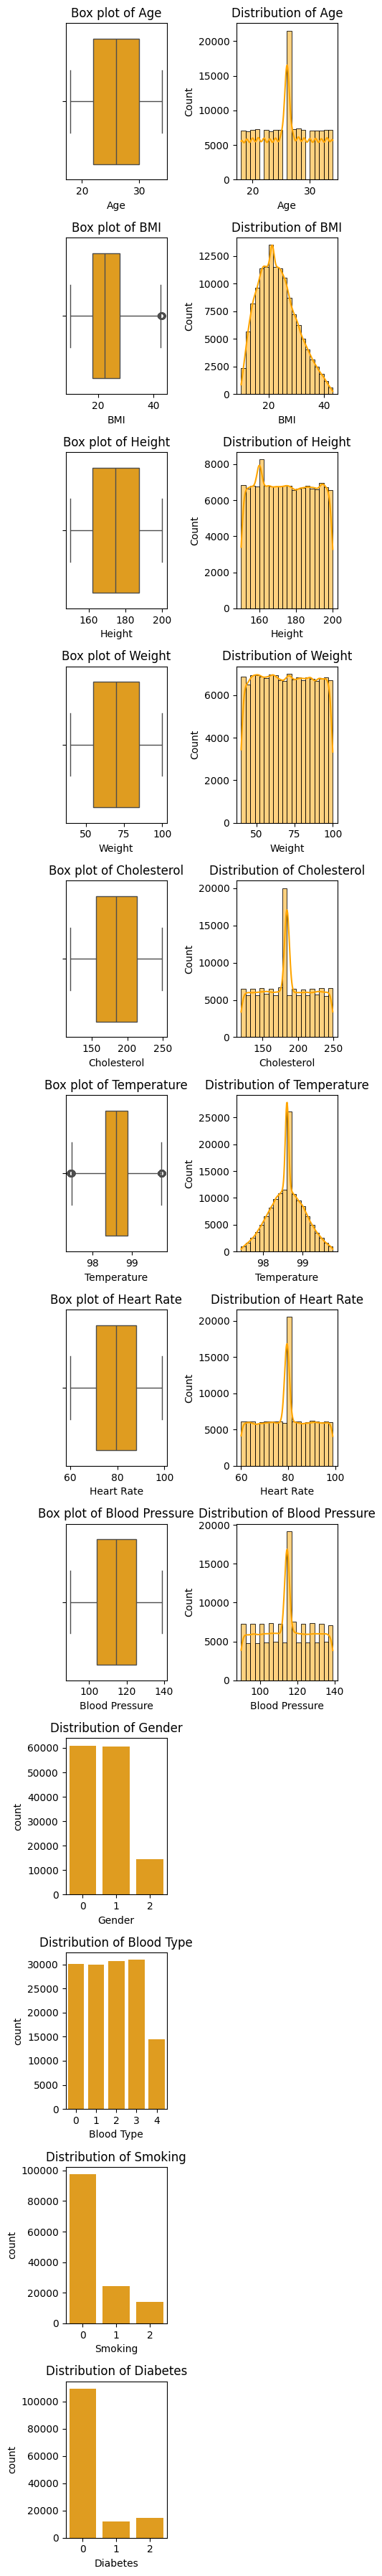

In [16]:
def remove_outliers_iqr(df, numerical_columns):
    """
    Removes outliers from the DataFrame using the IQR technique.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        numerical_columns (list): List of numerical columns to check for outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds to identify outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter the data to remove rows with outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
    return df

# Example usage
numerical_columns = ['Age', 'BMI', 'Height', 'Weight', 'Cholesterol', 'Temperature', 'Heart Rate', 'Blood Pressure']

# Remove outliers from the DataFrame
df_cleaned = remove_outliers_iqr(df, numerical_columns)

# After removing outliers, you can plot the box plots and distribution graphs again
plot_box_and_distribution(df_cleaned, numerical_columns, categorical_columns)


In [17]:
# Define column lists
categorical_columns = ['Blood Type', 'Gender', 'Smoking']
numerical_columns = ['Temperature', 'Heart Rate', 'Blood Pressure', 'Cholesterol', 'Age']
columns_for_knn = ['Diabetes']
numerical_computation = ['Height', 'Weight', 'BMI']

# Wrap custom functions using FunctionTransformer
HWBMI = FunctionTransformer(compute_and_impute_remaining_values, validate=False)
BT_GS_Features = FunctionTransformer(impute_categorical_randomly, validate=False)
Numerical_imputation = FunctionTransformer(replace_nan_with_mean(df, ['Temperature', 'Heart Rate', 'Blood Pressure', 'Cholesterol', 'Age']), validate=False)
Outlier_Removal = FunctionTransformer(remove_outliers_iqr, validate=False)

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('User  defined function', HWBMI, numerical_computation),  # Compute and impute for Height, Weight, BMI
        ('replace with mean', Numerical_imputation, numerical_columns),  # Impute NaN for numerical columns
        ('RANDOM', BT_GS_Features, categorical_columns),  # Impute NaN for categorical columns
        # Note: KNN imputation for Diabetes should be handled separately in the model training phase
    ]
)

# Wrap Preprocessing and Outlier Removal in a Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 2: Preprocessing
    ('classifier', MultiOutputClassifier(LogisticRegression()))  # Step 3: Multi-output Classifier
])

# Example usage:
# Assuming `X` is your feature DataFrame and `y` is the target column:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# predictions = pipeline.predict(X_test)

In [18]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('User  defined function',
                                                  FunctionTransformer(func=<function compute_and_impute_remaining_values at 0x0000011D376080E0>),
                                                  ['Height', 'Weight', 'BMI']),
                                                 ('replace with mean',
                                                  FunctionTransformer(func=              Age  Gender      Height     Weight  Blood Type        BMI  \
0       18.000000       0  161.777924  72.354947           3  27.645835   
1       26.021279       1  152.069157  47.63...
199999    98.595817        95.0      133.000000        132.0         2   

        Smoking  
0             2  
1             0  
2             0  
3             1  
4             0  
...         ...  
199995        0  
199996        1  
199997        0  
199998        0  
199999        0  

[190704 rows x 12 columns]),
                                                  ['Temperature', 'Heart Rate',
                                                   'Blood Pressure',
                                                   'Cholesterol', 'Age']),
                                                 ('RANDOM',
                                                  FunctionTransformer(func=<function impute_categorical_randomly at 0x0000011D37608680>),
                                                  ['Blood Type', 'Gender',
                                                   'Smoking'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression()))])

In [19]:
# Wrap custom functions using FunctionTransformer
HWBMI = FunctionTransformer(compute_and_impute_remaining_values, validate=False)
BT_GS_Features = FunctionTransformer(impute_categorical_randomly, validate=False)
Numerical_imputation = FunctionTransformer(replace_nan_with_mean, validate=False)
Outlier_Removal = FunctionTransformer(remove_outliers_iqr, validate=False)

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('User  defined function', HWBMI, numerical_computation),  # Compute and impute for Height, Weight, BMI
        ('replace with mean', Numerical_imputation, numerical_columns),  # Impute NaN for numerical columns
        ('RANDOM', BT_GS_Features, categorical_columns),  # Impute NaN for categorical columns
    ]
)

# Wrap Preprocessing and Outlier Removal in a Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 2: Preprocessing
    ('classifier', MultiOutputClassifier(LogisticRegression()))  # Step 3: Multi-output Classifier
])



In [20]:
# Fit the pipeline
pipeline.fit(X_train, Y_train)

# Make predictions
predictions = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(Y_test, predictions))

RecursionError: maximum recursion depth exceeded